In [1]:
%matplotlib inline
import pandas as pd
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
from fbprophet import Prophet
import optuna
import mlflow
from statsmodels.tsa.ar_model import AutoReg

In [2]:
data = pd.read_csv('./per_liter_clean.csv')

In [3]:
data.dtypes

Unnamed:_0                         int64
DATA_INICIAL                      object
DATA_FINAL                        object
REGIAO                            object
ESTADO                            object
PRODUTO                           object
NUMERO_DE_POSTOS_PESQUISADOS       int64
UNIDADE_DE_MEDIDA                 object
PRECO_MEDIO_REVENDA              float64
DESVIO_PADRAO_REVENDA            float64
PRECO_MINIMO_REVENDA             float64
PRECO_MAXIMO_REVENDA             float64
MARGEM_MEDIA_REVENDA             float64
COEF_DE_VARIACAO_REVENDA         float64
PRECO_MEDIO_DISTRIBUICAO         float64
DESVIO_PADRAO_DISTRIBUICAO       float64
PRECO_MINIMO_DISTRIBUICAO        float64
PRECO_MAXIMO_DISTRIBUICAO        float64
COEF_DE_VARIACAO_DISTRIBUICAO    float64
MES                                int64
ANO                                int64
dtype: object

In [4]:
data['DATA_INICIAL'] = pd.to_datetime(data['DATA_INICIAL'])
data['DATA_FINAL'] = pd.to_datetime(data['DATA_FINAL'])

In [5]:
for colname in ['REGIAO', 'ESTADO', 'PRODUTO']:
    data[colname] = data[colname].astype('category')

data[['REGIAO', 'ESTADO', 'PRODUTO']].dtypes

REGIAO     category
ESTADO     category
PRODUTO    category
dtype: object

Os dados lidos apresentam vários estados e produtos, implicando diferentes previsões para cada. Nos atendo aos propósitos deste projeto, preveremos somente para Pernambuco e o produto mais comum.

In [6]:
data['ESTADO'].unique()

['DISTRITO FEDERAL', 'GOIAS', 'MATO GROSSO', 'MATO GROSSO DO SUL', 'ALAGOAS', ..., 'SAO PAULO', 'PARANA', 'RIO GRANDE DO SUL', 'SANTA CATARINA', 'PARA']
Length: 27
Categories (27, object): ['DISTRITO FEDERAL', 'GOIAS', 'MATO GROSSO', 'MATO GROSSO DO SUL', ..., 'PARANA', 'RIO GRANDE DO SUL', 'SANTA CATARINA', 'PARA']

In [7]:
data_pern = data[data['ESTADO'] == 'PERNAMBUCO']
len(data_pern)

2645

In [8]:
for p in data_pern['PRODUTO'].unique():
    print(f'Quantidade de {p}: {(data_pern["PRODUTO"] == p).sum()}')

Quantidade de ETANOL HIDRATADO: 782
Quantidade de GASOLINA COMUM: 749
Quantidade de ÓLEO DIESEL: 776
Quantidade de ÓLEO DIESEL S10: 338


In [9]:
data_pern = data_pern[data_pern['PRODUTO'] == 'ETANOL HIDRATADO']

In [10]:
data_pern.index = data_pern['DATA_INICIAL']

Preveremos o preço médio de revenda, utilizando ARIMA inicialmente

In [11]:
data_pern.index.max()

Timestamp('2019-06-23 00:00:00')

Dado que temos informações desde 2004 até o final do primeiro semestre de 2019, podemos dividir os dados em treinamento até o final do primeiro semestre de 2018, validação desse ponto até o final do segundo semestre de 2018, e teste o que resta. Vamos também obter os dados médios por mês, para poder usar 12 como parâmetro de sazonalidade do SARIMAX.

In [12]:
data_pern = data_pern.resample('m').mean()

In [13]:
data_pern_train = data_pern[:'2018-06']
data_pern_validation = data_pern['2018-07':'2018-12']
data_pern_test = data_pern['2019-01':'2019-06']

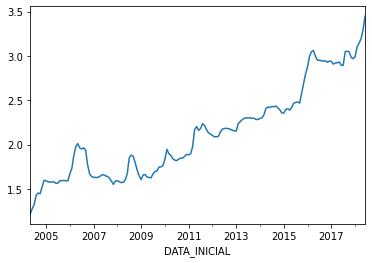

In [14]:
data_pern_train['PRECO_MEDIO_REVENDA'].plot()

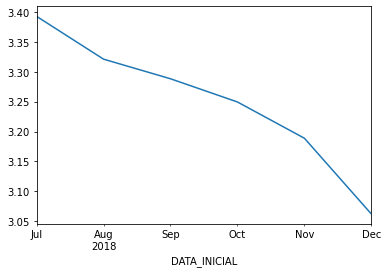

In [15]:
data_pern_validation['PRECO_MEDIO_REVENDA'].plot()

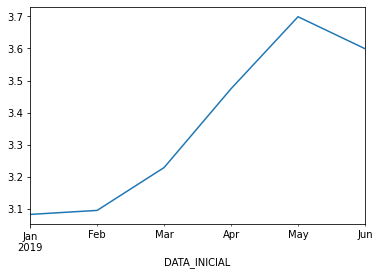

In [16]:
data_pern_test['PRECO_MEDIO_REVENDA'].plot()

Vamos agora realizar uma grid-search para determinar os melhores parâmetros para o algoritmo

In [17]:
y = data_pern_train['PRECO_MEDIO_REVENDA']

In [18]:
def objective(trial):
    p = trial.suggest_int('p', 0, 2)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 2)

    ps = trial.suggest_int('ps', 0, 2)
    ds = trial.suggest_int('ds', 0, 2)
    qs = trial.suggest_int('qs', 0, 0)

    mdl = sm.tsa.statespace.SARIMAX(
        y,
        order=(p, d, q),
        seasonal_order=(ps, ds, qs, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    results = mdl.fit()

    trial.report(results.aic, 0)

    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return results.aic

In [19]:
def print_study_best_trial_params(study):
    t = study.best_trial

    print(f'Melhor valor: {t.value}')

    print(f'Melhores parâmetros:')

    for p, v in t.params.items():
        print(f'{p}: {v}')

In [20]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=300)

print_study_best_trial_params(study)

NameError: NameError: name 'optuna' is not defined

Determinados os melhores parâmetros, vamos treinar o nosso modelo e realizar uma previsão

In [21]:
pdq = (2, 0, 1)
pdqs = (0, 0, 0, 12)

mod = sm.tsa.statespace.SARIMAX(
    y,
    order=pdq,
    seasonal_order=pdqs,
    enforce_stationarity=False,
    enforce_invertibility=False
)

res = mod.fit()

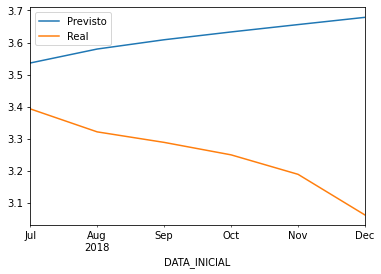

In [22]:
predicted = res.get_prediction(start='2018-07', end='2018-12')
predicted.predicted_mean.plot(label='Previsto')
data_pern_validation['PRECO_MEDIO_REVENDA'].plot(label='Real')
plt.legend()

Repitamos a previsão para o intervalo de tempo de teste

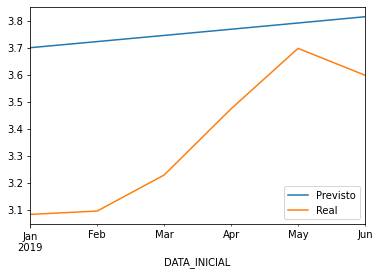

In [23]:
predicted_test = res.get_prediction(start = '2019-01', end='2019-06')
predicted_test.predicted_mean.plot(label='Previsto')
data_pern_test['PRECO_MEDIO_REVENDA'].plot(label='Real')
plt.legend()

MSE (Mean Squared Error):

In [24]:
((predicted_test.predicted_mean - data_pern_test['PRECO_MEDIO_REVENDA']) ** 2).mean()

0.1976932543934502

### Prophet

In [25]:
prophet_df = pd.DataFrame()
prophet_df['y'] = data_pern_train['PRECO_MEDIO_REVENDA']
prophet_df['ds'] = data_pern_train.index

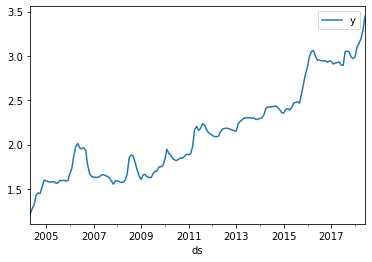

In [26]:
prophet_df.plot(x='ds')

In [27]:
def prophet_objective(trial):
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', .001, .5)
    seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', .01, 10)
    holidays_prior_scale = trial.suggest_float('holidays_prior_scale', .01, 10)

    prophet = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale
    )

    prophet.fit(prophet_df)

    future_df = prophet.make_future_dataframe(periods=6, freq='m')
    future_pred = prophet.predict(future_df)

    mse = ((future_pred[-6:]['yhat'].reset_index(drop=True) - data_pern_validation['PRECO_MEDIO_REVENDA'].reset_index(drop=True)) ** 2).mean()

    trial.report(mse, 0)

    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return mse

In [28]:
prophet_study = optuna.create_study(direction="minimize")
prophet_study.optimize(prophet_objective, n_trials=80)

print_study_best_trial_params(prophet_study)

NameError: NameError: name 'optuna' is not defined

**Auto-regressão**

In [29]:
ar_df = pd.DataFrame()
ar_df['y'] = data_pern_train['PRECO_MEDIO_REVENDA']
ar_df['ds'] = data_pern_train.index
model = AutoReg(ar_df, lags=1)

NameError: NameError: name 'AutoReg' is not defined